In [30]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
import sys, time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, GlobalAveragePooling1D, Conv1DTranspose, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [26]:
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

In [13]:
MODEL = 0 # 0 = th v air, 1 = el v sky

In [14]:
index = [0,3] if MODEL==0 else [1,2]
model_name = 'th_v_air' if MODEL==0 else 'el_v_sky'

base_data_train, base_data_test = np.load('../../data/training_data/training_data_1month.npy', allow_pickle=True)
vae_data_train = np.load(f'../../data/vae_synthetic_data/{model_name}_generated_samples.npy')
vae_data_train_rescaled = np.load(f'../../data/vae_synthetic_data/{model_name}_rescaled_samples.npy')
base_data_train, base_data_test, vae_data_train = base_data_train[:,:,index], base_data_test[:,:,index], vae_data_train[:,:,[0,1]]
print(base_data_train.shape,vae_data_train.shape)

(108, 730, 2) (1000, 730, 2)


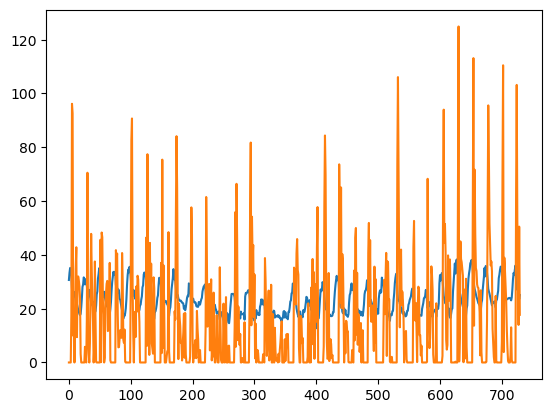

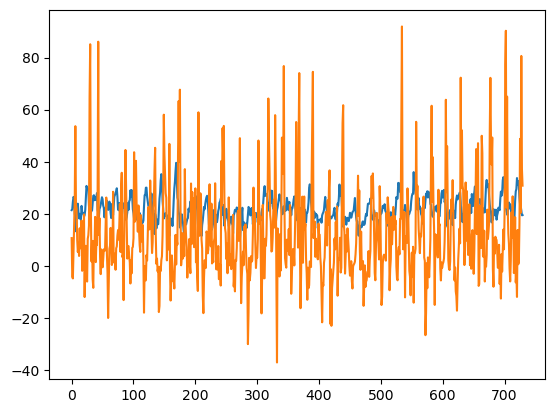

In [18]:
plt.plot(base_data_train[100])
plt.show()
plt.plot(vae_data_train_rescaled[100])
plt.show()

In [31]:
def create_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape,
            kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(730, activation='linear')
    ])
    return model

In [32]:
def test_lstm(training_data):
    X_train = training_data[:,:,0].reshape(-1,730,1)
    y_train = training_data[:,:,1]

    X_test = scaled_data_test[:,:,0].reshape(-1, 730, 1)  
    y_test = scaled_data_test[:,:,1]

    X_train, X_train_val, y_train, y_train_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
                                                                  
    model = create_lstm((X_train.shape[1], X_train.shape[2]))
    model.compile(optimizer=Adam(), loss='mse', metrics=['mse', 'mae', 'accuracy'])

    early_stopping = EarlyStopping(monitor='mse', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='mse', factor=0.5, patience=5, verbose=1)
    model.fit(X_train, y_train, epochs=100, batch_size=16, callbacks=[early_stopping, reduce_lr], verbose=1, validation_data=(X_train_val, y_train_val))

    loss, mse, mae, accuracy = model.evaluate(X_test, y_test)
    r2 = r_squared(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(model.predict(X_test), dtype=tf.float32))
    
    return {'mse':mse, 'mae':mae, 'r2':r2.numpy(), 'acc':accuracy}

In [33]:
from sklearn.preprocessing import MinMaxScaler

scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I']}

temp_var, energy_var = base_data_train[:,:,0], base_data_train[:,:,1]
temp_var_test, energy_var_test = base_data_test[:,:,0], base_data_test[:,:,1]

temp_var, temp_var_test = scalers['G.air.T'].fit_transform(temp_var), scalers['G.air.T'].fit_transform(temp_var_test)
energy_var, energy_var_test = scalers['G.E_th_I'].fit_transform(energy_var), scalers['G.E_th_I'].fit_transform(energy_var_test)

scaled_data_train, scaled_data_test = np.stack((temp_var, energy_var), axis=-1), np.stack((temp_var_test, energy_var_test), axis=-1)
print(scaled_data_train.shape, scaled_data_test.shape)

(108, 730, 2) (12, 730, 2)


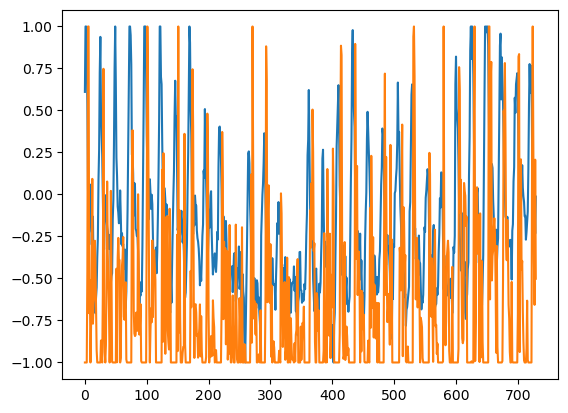

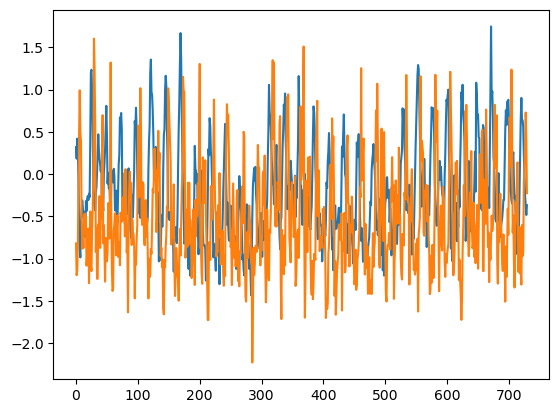

In [34]:
plt.plot(scaled_data_train[100])
plt.show()
plt.plot(vae_data_train[100])
plt.show()

In [35]:
import tensorflow as tf

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

<h3> LSTM to assess ground truth data </h3>

In [36]:
gt_test = test_lstm(scaled_data_train)
print(gt_test['mse'], gt_test['mae'], gt_test['r2'], gt_test['acc'])

Epoch 1/100


2024-03-25 17:40:33.443628: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


6/6 [==============================] - 14s 1s/step - loss: 0.7991 - mse: 0.6996 - mae: 0.7887 - accuracy: 0.0000e+00 - val_loss: 0.7872 - val_mse: 0.6921 - val_mae: 0.7852 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 2s 308ms/step - loss: 0.7754 - mse: 0.6827 - mae: 0.7788 - accuracy: 0.0000e+00 - val_loss: 0.7617 - val_mse: 0.6729 - val_mae: 0.7738 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 2s 303ms/step - loss: 0.7476 - mse: 0.6608 - mae: 0.7656 - accuracy: 0.0000e+00 - val_loss: 0.7285 - val_mse: 0.6449 - val_mae: 0.7569 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 2s 300ms/step - loss: 0.7096 - mse: 0.6276 - mae: 0.7453 - accuracy: 0.0000e+00 - val_loss: 0.6738 - val_mse: 0.5943 - val_mae: 0.7252 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 2s 308ms/step - loss: 0.6310 - mse: 0.5526 - mae: 0.6962 - 

<h3> LSTM to assess synthetic data </h3>

In [29]:
synth_test = test_lstm(vae_data_train[0:216,:,:])
print(synth_test['mse'], synth_test['mae'], synth_test['r2'], synth_test['acc'])

Epoch 1/100
11/11 [==============================] - 4s 253ms/step - loss: 0.6677 - mse: 0.6677 - mae: 0.7120 - accuracy: 0.0291 - val_loss: 0.6202 - val_mse: 0.6202 - val_mae: 0.6838 - val_accuracy: 0.0227 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 2s 218ms/step - loss: 0.6539 - mse: 0.6539 - mae: 0.7038 - accuracy: 0.0291 - val_loss: 0.6066 - val_mse: 0.6066 - val_mae: 0.6755 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 3s 244ms/step - loss: 0.6349 - mse: 0.6349 - mae: 0.6923 - accuracy: 0.0465 - val_loss: 0.5791 - val_mse: 0.5791 - val_mae: 0.6581 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 3s 229ms/step - loss: nan - mse: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mse: nan - val_mae: nan - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 2s 229ms/step - loss: nan - mse: nan - mae: nan - accuracy: 0.0000e+0

KeyboardInterrupt: 

<h3> LSTM to evaluate synthetic-ground truth blended data </h3>

In [ ]:
blended_data = np.concatenate((scaled_data_train, vae_data_train[0:216,:,:]), axis=0)
blended_test = test_cnn(blended_data)
print(blended_test['mse'], blended_test['mae'], blended_test['r2'], blended_test['acc'])